# Quality control

(surface-protein:motivation)=
## Motivation

In addition to capturing only transcriptomic data with single cell analyses, we are now able to also capture the abundance of surface protein expression. The protocol used for this is usually referred to as CITE-seq{cite}`sp:Stoeckius2017`. This modality requires different preprocessing compared to what we described earlier for gene expression data since the data distributions are different. In the following, we will guide you through the process of dealing with CITE-seq data. As CITE-seq data provides you with two different modalities, you can either analyze them separately or jointly. Here, we will focus on the ADT part of the data and analyze it unimodally.

Single-cell RNA-seq data acts as a proxy for protein level with a partial correlation at various transcription estates of a cell{cite}`Liu2016`. Therefore, it is in our interest to measure the protein levels in single-cells if we are to capture a better picture of cellular processes. Quantifying these aspects of a cell is essential to understand cell differentiation and fate, cell signal transduction pathway, disease progression, perturbations, and clinical diagnostics{cite}`Xie2022`.

We can already detect relevant populations with single-cell transcriptomics. This is a valuable piece of information, but incomplete if we want to better understand the cellular identities and dynamics happening in the biological processes we study. Having surface protein measurements allows us to close the gap between identity by transcription and identity by protein where there might be a delay in synthesis that could be important in our experiment. For example, it has been noted that ICOS, an immune checkpoint protein, was increased on the surface of treated cells, regardless of the fact that this protein’s mRNA does not differ in abundance between the treatment groups{cite}`Peterson2017`. Another advantage is that surface protein levels help us detect doublets that might not be reflected at the transcript level in our data. This is possible by looking at the co-occurrence of cell-type-specific markers{cite}`sp:Sun2021`.

By using antibodies tagged with a barcode, it is possible to first bind the antibodies to the cells and later sequence the barcodes together with the RNA. There are two main protocols CITE-seq (Cellular Indexing of Transcriptomes and Epitopes by Sequencing) and REAP-seq (RNA expression and protein sequencing assay). The main difference resides in their antibody-oligo conjugates also known as Antibody-Derived Tags (ADT). CITE-seq uses streptavidin that is noncovalently bound to biotinylated DNA barcodes. REAP-seq implements covalent bonds between the antibody and a DNA barcode{cite}`Peterson2017`. Furthermore, there have been advances integrating the CITE-seq protocol in a multimodal assay. One is DOGMA-seq{cite}`Mimitou2021`, an adaptation of CITE-seq that allows the measurement of chromatin accessibility, gene expression, and protein from the same cell. This method includes ASAP-seq, which combines scATAC-seq and ADT by adding a bridge oligo specific to the CITE-seq reagents{cite}`Mimitou2021`. The advantage of ASAP-seq is that it can measure surface and intracellular proteins. We will refer to the surface protein measurements as ADT data.

![CITE-Seq](https://citeseq.files.wordpress.com/2017/10/antibody_transparent.png)

With ADT data, we can identify cell types based on conventional markers usually utilized in flow cytometry experiments. These markers are especially useful for specific immune cell populations. The advantage of ADT is that other modalities are measured simultaneously. However, the way we process ADT data differs from others. Contrary to the negative binomial distribution of UMI counts, ADT data is less sparse with a negative peak for non-specific antibody binding and a positive peak resembling enrichment of specific cell surface proteins{cite}`Zheng2022`. Many experiments only include a small number in the tens or hundreds of antibodies of interest. Moreover, sequencing resources can be concentrated enabling deeper coverage of ADTs since they are separated from transcripts. ADT data is also noisier, as unbound antibodies lead to counts in cells or empty droplets where the protein is not present.

## Environment setup and data

We use a Cite-seq data set generated for a single cell data integration challenge at the NeurIPS conference 2021 {cite}`sp:Luecken_2021`. This dataset captures single-cell RNA and Antibody-Derived Tag (ADT) data from bone marrow mononuclear cells of 12 healthy human donors measured at four different sites to obtain nested batch effects. In this tutorial, we will use the whole dataset which contains 136 surface protein and 4 isotypes, and additionally show for one sample how to collect the data into a MuData object.

Subsequently, we will use scanpy and muon{cite}`Bredikhin_2022` to analyse the data.

We first start by importing all packages that are required for running this notebook.

In [1]:
import mudata as md
import muon as mu
import numpy as np
import pandas as pd
import pooch
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

### Collecting cellranger outputs into MuData object

Cell Ranger gives us two outputs: a filtered and a raw output. The raw output contains all sequenced droplets
while the filtered output only consists of the droplets considered as cells by Cell Ranger. We are collecting two subobjects into one MuData object that consists captures the RNA as well as the ADT data

In [2]:
rna = sc.read_10x_h5(
    filename="rna_filtered_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546196",
)
prot = sc.read_10x_h5(
    filename="prot_filtered_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/42569008",
)

We now create a MuData object based on the two modalities.

In [3]:
mdata = mu.MuData({"rna": rna, "prot": prot})
mdata

MuData object with n_obs × n_vars = 21737 × 73202
  2 modalities
    rna:	16934 x 36601
      var:	'gene_ids', 'feature_types', 'genome'
    prot:	4804 x 36601
      var:	'gene_ids', 'feature_types', 'genome'

As we can observe, the MuData object was successfully create and we can continue with our analysis. 

This chapter will use the entire Cite-seq dataset generated for the data integration challenge. As Mudata does not support concatenation, we used scanpy to concatenate the individual samples. We split each object into a GEX and an ADT anndata object, concatenate those individually and finally attach them to a new joint MuData object. We did this for both the filtered and the raw object. Individual raw and filtered h5 objects for all samples are available upon request.

In [4]:
rna_raw = sc.read_10x_h5(
    filename="rna_raw_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546217",
)
prot_raw = sc.read_10x_h5(
    filename="prot_raw_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/42569026",
)
mdata_raw = mu.MuData({"rna": rna_raw, "prot": prot_raw})
mdata_raw

MuData object with n_obs × n_vars = 2874409 × 73202
  2 modalities
    rna:	692666 x 36601
      var:	'gene_ids', 'feature_types', 'genome'
    prot:	2184484 x 36601
      var:	'gene_ids', 'feature_types', 'genome'

### Loading the complete MuData object

Next, we are now actually loading the complete Cite-seq dataset from the single cell data integration challenge at the NeurIPS conference 2021 {cite}`sp:Luecken_2021`. We collected for all samples the RNA and ADT cellranger outputs, concatenated the individual objects and then created a joint MuData object in a similar way as described above. 

In [5]:
cite_filtered = pooch.retrieve(
    url="https://figshare.com/ndownloader/files/41452287",
    fname="cite_filtered.h5mu",
    path=".",
    known_hash=None,
    progressbar=True,
)

In [6]:
cite_raw = pooch.retrieve(
    url="https://figshare.com/ndownloader/files/41452308",
    fname="cite_raw.h5mu",
    path=".",
    known_hash=None,
    progressbar=True,
)

In [7]:
mdata = md.read_h5mu("cite_filtered.h5mu")
mdata

MuData object with n_obs × n_vars = 122016 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	122016 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	122016 x 140
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'

In [8]:
mdata_raw = md.read_h5mu("cite_raw.h5mu")
mdata_raw

MuData object with n_obs × n_vars = 24807643 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	24807643 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	24807643 x 140
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'

Now, we have two Mudata objects. `mdata_raw` contains the unfiltered barcode x features MuData object and `mdata` contains all barcodes that passed the cellranger filtering. While the raw object contains over 24 million droplets, the filtered object only contains 122,016. The `rna` modality has 36601 features while the `prot` modality has 140 features.

## Quality Control

Similar to transcriptomics data quality control and filtering, we need to remove cells that failed to capture ADTs. Solely reusing the earlier introduced transcriptomics quality control measures is inappropriate due to the above-mentioned different distributions.
Since features for CITE-seq experiments are chosen based on expected biological relevance, separating technical and biological artifacts is more challenging.

Successful capture of targeted proteins leads to a massive increase of total ADT count, due to the binary nature of surface markers. Caution is required when removing cells with low total ADT counts, since many cell types do not express the selected protein targets.
Empty droplets however still contain reads for ADT counts because unbound antibodies are sequenced.
We therefore expect non-zero counts for most ADTs.
We can, however make use of these empty droplets to normalize our count data as we can consider this as the ambient background level for each antibody.
This is discussed at a later point.

In [9]:
sc.pp.calculate_qc_metrics(mdata["prot"], inplace=True, percent_top=None)
sc.pp.calculate_qc_metrics(mdata_raw["prot"], inplace=True, percent_top=None)
sc.pp.calculate_qc_metrics(mdata_raw["rna"], inplace=True, percent_top=None)

We first look at the distribution of ADTs per cell over all samples. We plot this using the seaborn library. We first take a look at the whole range and can see that most cells
express between 70 and 140 proteins.

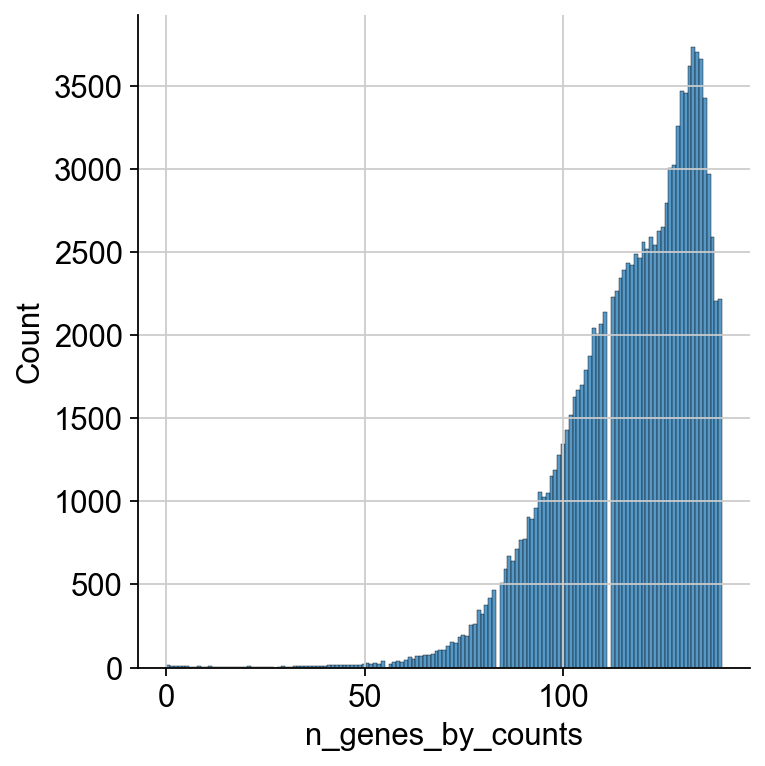

In [10]:
sns.displot(mdata["prot"].obs.n_genes_by_counts)

As the cells falling below a certain threshold of present ADT markers and not following the distribution are probably not viable cells, we want to filter out those cells.
Thus, we look at the lower end of the distribution.

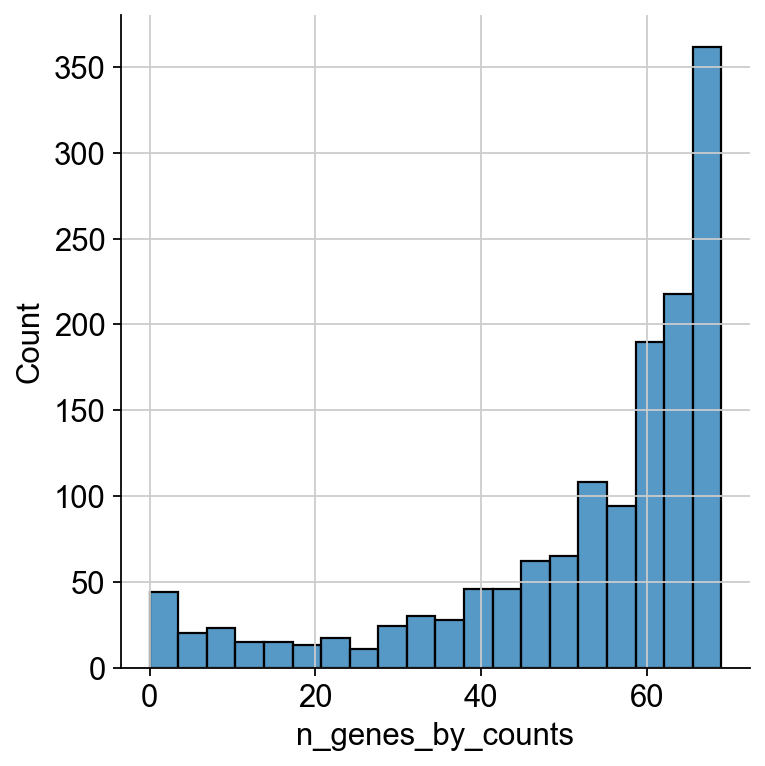

In [11]:
sns.displot(
    mdata["prot"][mdata["prot"].obs.n_genes_by_counts < 70].obs.n_genes_by_counts
)

We can see a 'valley' in the distribution at around 55 ADTs. This looks like an appropriate cutoff.

Next, we do the same thing based on total counts per cell. Looking at the total range, we can't see any apparent ranges of the distribution of counts.

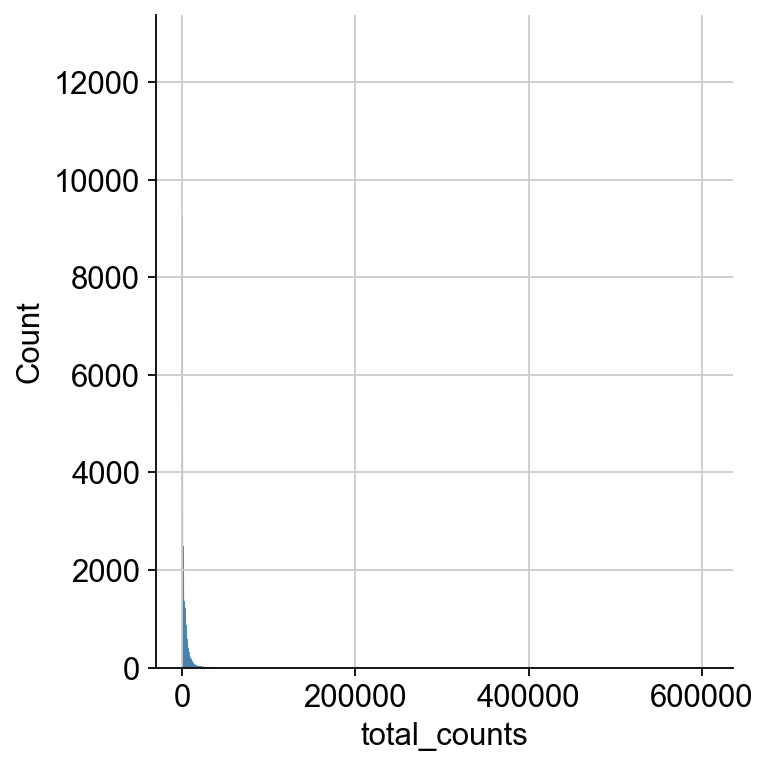

In [12]:
sns.displot(mdata["prot"].obs.total_counts)

We zoom in to see the upper end of the distribution for the total counts to decide on a cutoff for the maximum number of counts as droplets exceeding a certain threshold probably contain multiple cells, so called doublets.

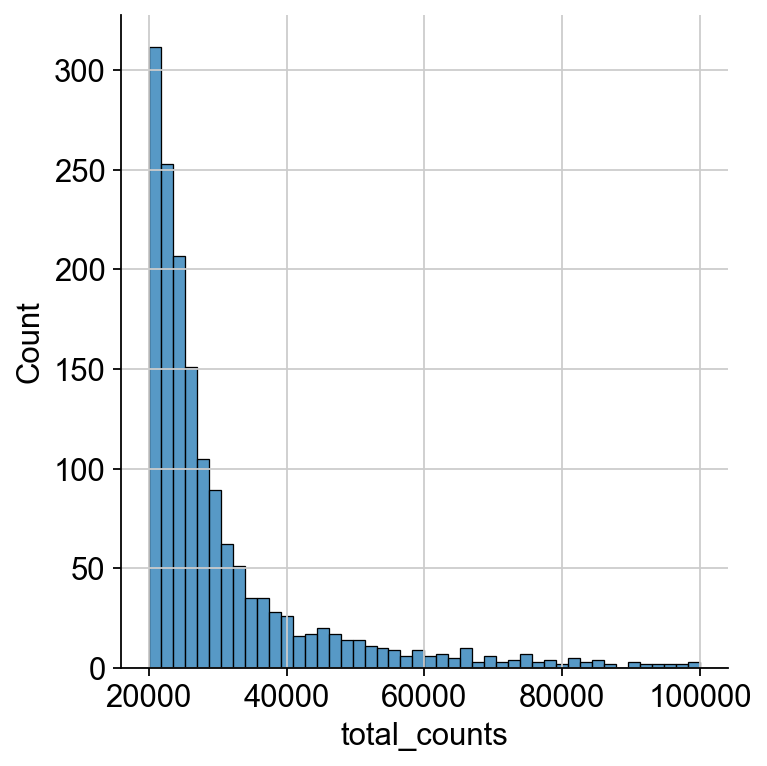

In [13]:
sns.displot(
    mdata["prot"].obs.query("total_counts>20000 and total_counts<100000").total_counts
)

For the `dsb` normalization performed later, we need to take a look at the raw rna count distribution. The first large peak between 10\*\*1 and 10\*\*2.1 are droplets that don't contain cells, thus we can use this range for the dsb algorithm at a later stage.

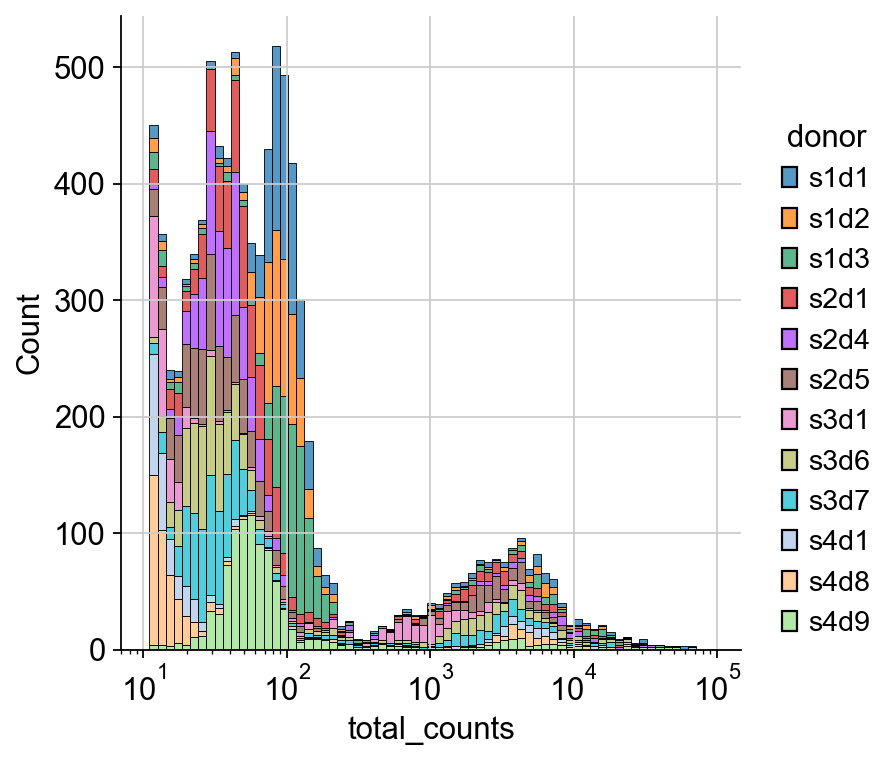

In [14]:
sns.displot(
    mdata_raw["rna"]
    .obs.sample(frac=0.01)
    .query("total_counts<100000 and total_counts>10"),
    x="total_counts",
    log_scale=True,
    hue="donor",
    multiple="stack",
)

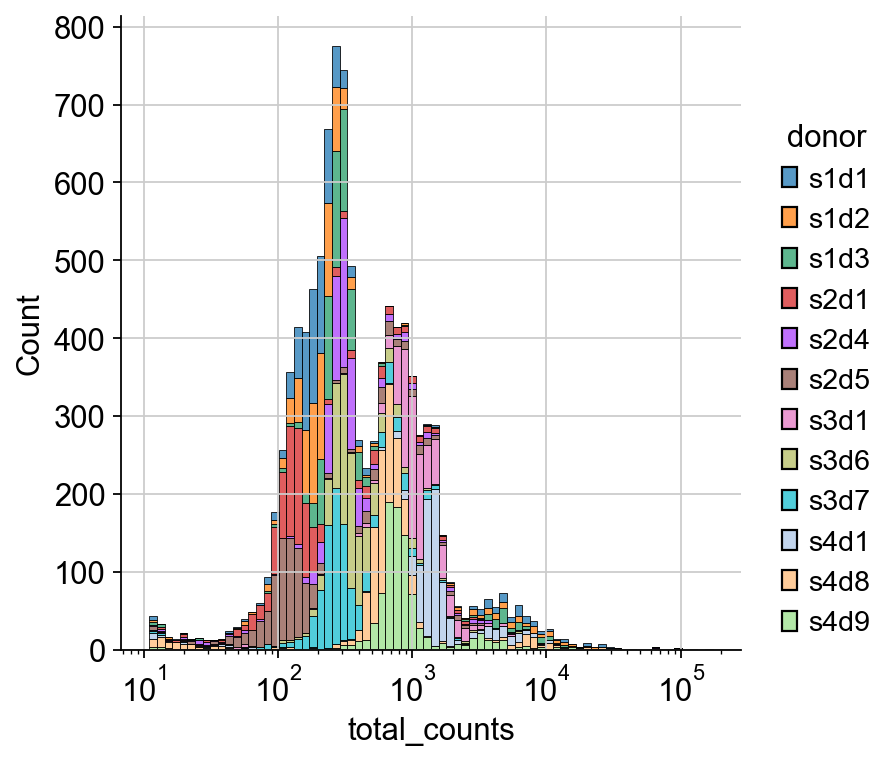

In [15]:
sns.displot(
    mdata_raw["prot"].obs.sample(frac=0.01).query("total_counts>10"),
    x="total_counts",
    log_scale=True,
    hue="donor",
    multiple="stack",
)

In [16]:
mdata

MuData object with n_obs × n_vars = 122016 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	122016 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	122016 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Sample-wise QC

Now we look at the distribution of counts per cell across the samples to see if there are differences. As the total amount of reads and droplets can differ between the samples, a stringent, hard cutoff applied to all samples would not be appropriate.

In [17]:
sc.pp.filter_cells(mdata["prot"], max_counts=100000)

<Axes: xlabel='donor', ylabel='total_counts'>

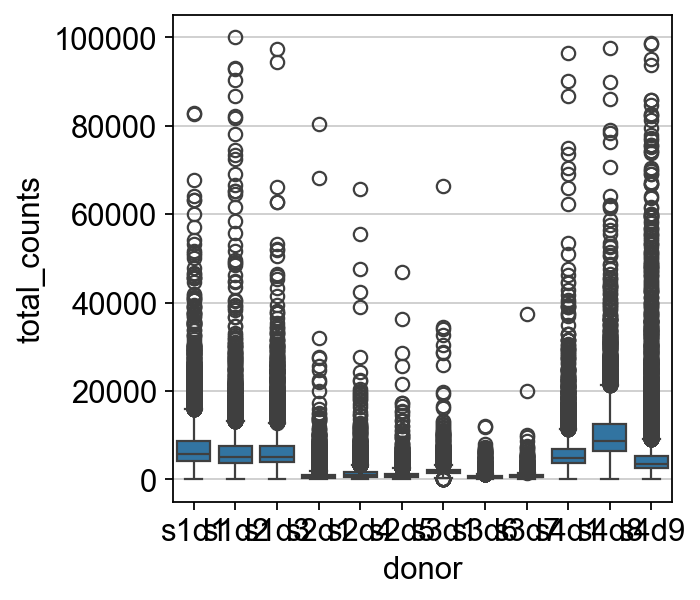

In [18]:
sns.boxplot(y=mdata["prot"].obs.total_counts, x=mdata["prot"].obs["donor"])

The distributions of counts are different between samples. Thus, sample-wise QC is deemed pertinent.
If we compare sample s3d7 vs sample s4d8, we can see that the outliers of one sample would fit the regular distribution of normal counts in the other sample.

Since we have a significant number of samples we can do sample-wise QC automatically as described in the RNA preprocessing chapter.

In [19]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [20]:
outliers = []
for sample in np.unique(mdata["prot"].obs["donor"]):
    adata_temp = mdata["prot"][mdata["prot"].obs["donor"] == sample].copy()
    adata_temp.obs["outlier"] = is_outlier(
        adata_temp, "log1p_total_counts", 5
    ) | is_outlier(adata_temp, "log1p_n_genes_by_counts", 5)
    outliers.append(adata_temp.obs["outlier"])
    print(f"{sample}: outliers {adata_temp.obs.outlier.value_counts()[True]}")

s1d1: outliers 206
s1d2: outliers 209
s1d3: outliers 227
s2d1: outliers 340
s2d4: outliers 189
s2d5: outliers 150
s3d1: outliers 339
s3d6: outliers 492
s3d7: outliers 338
s4d1: outliers 245
s4d8: outliers 184
s4d9: outliers 499


In [21]:
mdata["prot"].obs["outliers"] = pd.concat(outliers)

In [22]:
mdata["prot"].obs.head()

,donor,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,n_counts,outliers
AAACCCAAGGATGGCT-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,124,4.828314,6483.0,8.777093,6483.0,False
AAACCCAAGGCCTAGA-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,140,4.948760,19711.0,9.888983,19711.0,False
AAACCCAAGTGAGTGC-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,120,4.795791,3349.0,8.116715,3349.0,False
AAACCCACAAGAGGCT-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,128,4.859812,7841.0,8.967249,7841.0,False
AAACCCACATCGTGGC-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,114,4.744932,2462.0,7.809135,2462.0,False


Let's first update our MuData (.obs and .var) with the data from all the modalities.

In [23]:
mdata.update()

In [24]:
mdata = mdata[mdata.obs.loc[mdata["prot"].obs_names].index]

In [25]:
mdata = mdata[mdata["prot"].obs["outliers"] is False]

In [26]:
mdata

View of MuData object with n_obs × n_vars = 118563 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	118563 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	118563 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

We removed 1500 cells during the filtering which equates to roughly 1% of cells. This is a relatively permissive filtering and we might need further filtering of doublets in the following.

<Axes: xlabel='donor', ylabel='total_counts'>

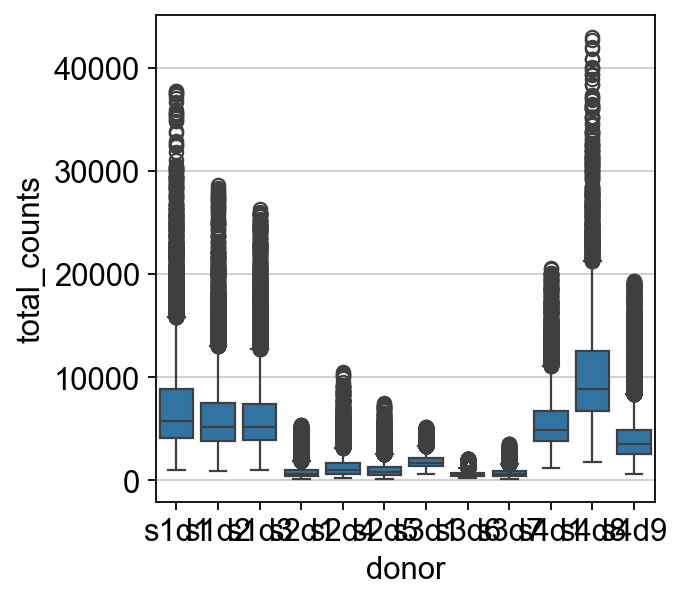

In [27]:
sns.boxplot(y=mdata["prot"].obs.total_counts, x=mdata["prot"].obs["donor"])

As we can see in the above plot, outliers are now filtered out for each sample separately. To now bring the values for each sample into a similar range, we need to normalize the data.

In [28]:
mdata.write("cite_quality_control.h5mu")

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: sp
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Daniel Strobl
* Ciro Ramírez-Suástegui
* Anna Schaar

### Reviewers

* Lukas Heumos